# monocle and slingshot pseudotime estimations for T cell Ref and ATO datasets (DN onwards)

In [1]:
import numpy as np
import seaborn as sns
import anndata
import os
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
#import dandelion as ddl
#ddl.logging.print_header() #sc.logging.print_header()
anndata.__version__

'0.9.1'

In [2]:
%load_ext rpy2.ipython 

In [3]:
input_dir ='../GOOGLE_DRIVE_MOUNT/G2G_Analysis/G2G_paper_related/'
adata_healthy = anndata.read_h5ad(input_dir+'PanfetalATO_SPT_DNonwards_gplvm_ref_24012023.h5ad')
adata_disease = anndata.read_h5ad(input_dir +'PanfetalATO_SPT_DNonwards_gplvm_ATO_24012023.h5ad')

print(adata_healthy.X.data)
print(adata_disease.X.data)

adata_healthy_original = adata_healthy.copy()
adata_disease_original = adata_disease.copy()

# from literature
#AT2_progenitor_markers = ['AXIN2','FGFR2', 'ID2', 'FZD6','LRP5','LRP6'] 

[1.6558038 1.6558038 1.6558038 ... 0.9572873 0.9572873 0.9572873]
[0.5900355  0.3379185  0.5900355  ... 0.45287    0.25185528 1.0000652 ]


/home/jovyan/my-conda-envs/capital/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:364: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


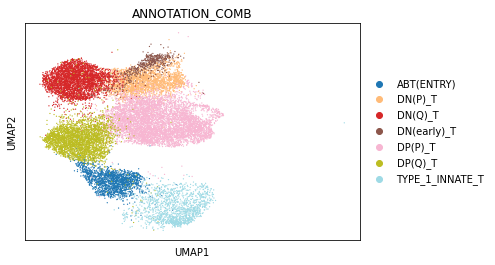

/home/jovyan/my-conda-envs/capital/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:364: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


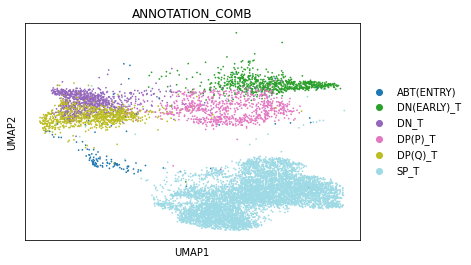

In [4]:
sc.pl.umap(adata_healthy, color='ANNOTATION_COMB')
sc.pl.umap(adata_disease, color='ANNOTATION_COMB')

In [18]:
np.random.seed(1234)

np.random.choice(np.where(adata_healthy.obs.ANNOTATION_COMB == 'DN(early)_T')[0]) 

7976

# monocle3

[1. 1. 1. ... 1. 1. 1.]


7976


/tmp/ipykernel_1592/2243435233.py:12: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['iroot'] = rootcell
/tmp/ipykernel_1592/2243435233.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs['rootcell'][rootcell] = 1
/home/jovyan/my-conda-envs/capital/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:364: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


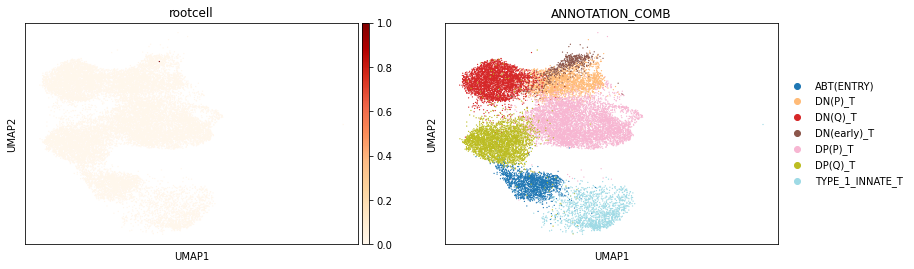

In [19]:
adata = adata_healthy_original.copy() 
adata.X = adata.layers['counts']
print(adata.X.data)
sc.pp.normalize_per_cell(adata, 10000) 
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=4000)
#sc.tl.score_genes(adata, gene_list=AT2_progenitor_markers, score_name='start_score')
adata = adata[:, adata.var.highly_variable]    
#rootcell = np.argmax(adata.obs.start_score)
rootcell = 7976
print(rootcell)
adata.uns['iroot'] = rootcell
adata.obs['rootcell'] = 0
adata.obs['rootcell'][rootcell] = 1
sc.pl.umap(adata,color=['rootcell','ANNOTATION_COMB'],color_map='OrRd')
#data prep for monocle3. need to subset the obs as rpy2 doesn't handle categoricals well now apparently
obs = adata.obs[['ANNOTATION_COMB']]
pca = adata.obsm['X_umap']
iroot = adata.obs_names[adata.obs['rootcell']==1]
expression = adata.X.todense() 
expression = np.matrix(expression) .transpose() 
pca = adata.obsm['X_umap']

[1] ‘0.2.3.0’
[1]  4000 18436
  |======================================================================| 100%


Loading required package: Biobase
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min

Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'br

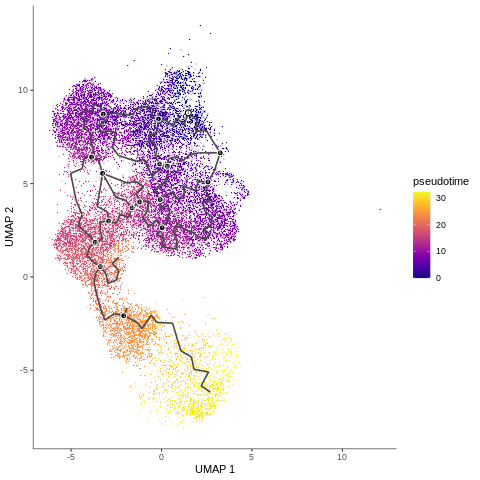

In [20]:
%%R -i obs -i expression -i pca -i iroot -o pseudotime 
        
library(monocle3)
print(packageVersion("monocle3"))

#create basic monocle object
#X = matrix(0,nrow=4000,ncol=dim(obs)[1])
mono = new_cell_data_set(expression, cell_metadata=obs)
print(dim(mono))

#hack in the UMAP into the appropriate object slot
umap = as.matrix(pca)
rownames(umap) = rownames(obs)
reducedDims(mono) = SimpleList(UMAP=umap)

#identify pseudotime graph structure, compute pseudotime
mono = cluster_cells(mono, reduction_method='UMAP')
mono = learn_graph(mono)
mono = order_cells(mono, root_cells=iroot)
pseudotime = mono@principal_graph_aux[['UMAP']]$pseudotime

#plot the various branchings R-side as this doesn't lend itself nicely to python porting
plot_cells(mono,
           color_cells_by = "pseudotime",
           label_cell_groups=FALSE,
           label_leaves=FALSE,
           label_branch_points=TRUE,
           graph_label_size=1.5)

/home/jovyan/my-conda-envs/capital/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:364: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


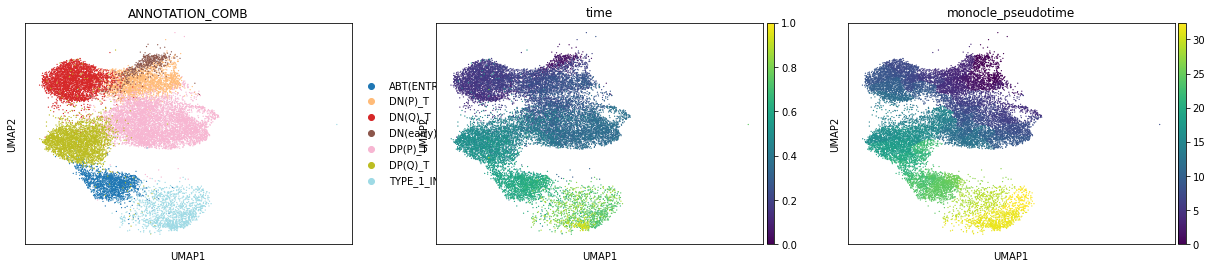

In [21]:
adata.obs['monocle_pseudotime'] = pseudotime
adata_healthy_original.obs['monocle_pseudotime'] = adata.obs['monocle_pseudotime']
sc.pl.umap(adata_healthy_original, color=['ANNOTATION_COMB','time', 'monocle_pseudotime' ])

In [22]:
adata_disease.obs.ANNOTATION_COMB

AAACCTGCAACTGGCC-1-2    DN(EARLY)_T
AAACGGGTCCCTCAGT-1-2    DN(EARLY)_T
AAACGGGTCTTGACGA-1-2    DN(EARLY)_T
AAAGATGGTTCCGGCA-1-2    DN(EARLY)_T
AAAGTAGTCAAACCAC-1-2    DN(EARLY)_T
                           ...     
TTTGTCACAGGGTACA-1-5           SP_T
TTTGTCAGTAGCACGA-1-5           SP_T
TTTGTCAGTAGTGAAT-1-5        DP(P)_T
TTTGTCATCGGATGTT-1-5        DP(P)_T
AGCTTGATCGTGGGAA-1-7    DN(EARLY)_T
Name: ANNOTATION_COMB, Length: 10089, dtype: category
Categories (6, object): ['ABT(ENTRY)', 'DN(EARLY)_T', 'DN_T', 'DP(P)_T', 'DP(Q)_T', 'SP_T']

In [23]:
np.where(adata_disease.obs.ANNOTATION_COMB == 'IPSC') 

(array([], dtype=int64),)

In [25]:
np.random.seed(1234)

np.random.choice(np.where(adata_disease.obs.ANNOTATION_COMB == 'DN(EARLY)_T')[0]) 

730

[2. 1. 2. ... 2. 1. 6.]


730


/tmp/ipykernel_1592/3094579473.py:13: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['iroot'] = rootcell
/tmp/ipykernel_1592/3094579473.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs['rootcell'][rootcell] = 1
/home/jovyan/my-conda-envs/capital/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:364: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


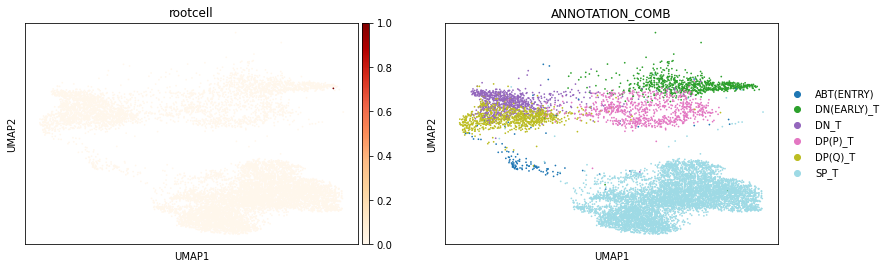

In [26]:
adata = adata_disease_original.copy() 
 
adata.X = adata.layers['counts']
print(adata.X.data)
sc.pp.normalize_per_cell(adata, 10000) 
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=4000)
#sc.tl.score_genes(adata, gene_list=AT2_progenitor_markers, score_name='start_score')
adata = adata[:, adata.var.highly_variable]    
#rootcell = np.argmax(adata.obs.start_score)
rootcell = 730
print(rootcell)
adata.uns['iroot'] = rootcell
adata.obs['rootcell'] = 0
adata.obs['rootcell'][rootcell] = 1
sc.pl.umap(adata,color=['rootcell','ANNOTATION_COMB'],color_map='OrRd')
#data prep for monocle3. need to subset the obs as rpy2 doesn't handle categoricals well now apparently
obs = adata.obs[['ANNOTATION_COMB']]
pca = adata.obsm['X_umap']
iroot = adata.obs_names[adata.obs['rootcell']==1]
expression = adata.X.todense() 
expression = np.matrix(expression) .transpose() 
pca = adata.obsm['X_umap']

[1] ‘0.2.3.0’
[1]  4000 10089
  |======================================================================| 100%


In addition: Warning message:
In new_cell_data_set(expression, cell_metadata = obs) :


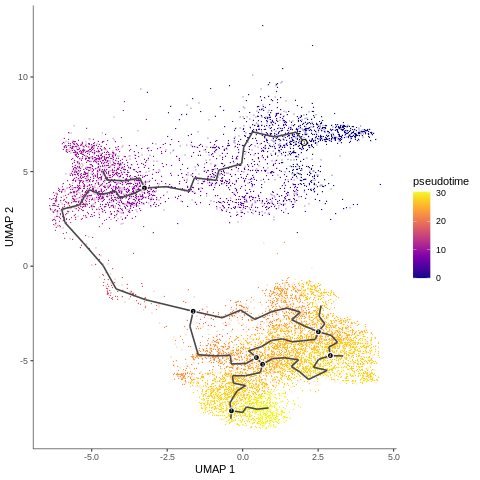

In [27]:
%%R -i obs -i expression -i pca -i iroot -o pseudotime 
        
library(monocle3)
print(packageVersion("monocle3"))

#create basic monocle object
#X = matrix(0,nrow=4000,ncol=dim(obs)[1])
mono = new_cell_data_set(expression, cell_metadata=obs)
print(dim(mono))

#hack in the UMAP into the appropriate object slot
umap = as.matrix(pca)
rownames(umap) = rownames(obs)
reducedDims(mono) = SimpleList(UMAP=umap)

#identify pseudotime graph structure, compute pseudotime
mono = cluster_cells(mono, reduction_method='UMAP')
mono = learn_graph(mono)
mono = order_cells(mono, root_cells=iroot)
pseudotime = mono@principal_graph_aux[['UMAP']]$pseudotime



#plot the various branchings R-side as this doesn't lend itself nicely to python porting
plot_cells(mono,
           color_cells_by = "pseudotime",
           label_cell_groups=FALSE,
           label_leaves=FALSE,
           label_branch_points=TRUE,
           graph_label_size=1.5)

/home/jovyan/my-conda-envs/capital/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:364: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


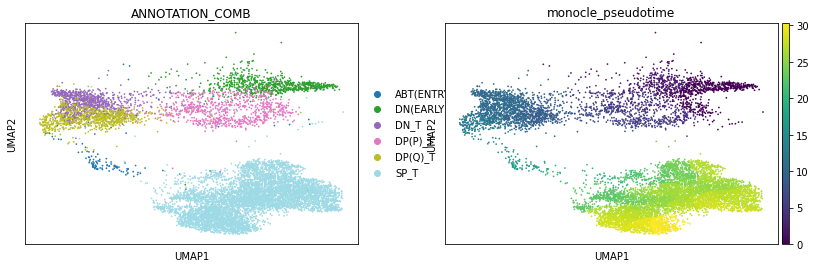

In [28]:
adata.obs['monocle_pseudotime'] = pseudotime
adata_disease_original.obs['monocle_pseudotime'] = adata.obs['monocle_pseudotime']
sc.pl.umap(adata_disease_original, color=['ANNOTATION_COMB', 'monocle_pseudotime' ])

# Slingshot 

In [16]:
#pip install pyslingshot

array([1., 1., 4., ..., 1., 1., 1.], dtype=float32)

/home/jovyan/my-conda-envs/capital/lib/python3.8/site-packages/pyslingshot/slingshot.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


Lineages: [Lineage[1, 2], Lineage[1, 3], Lineage[1, 4, 5, 0, 6]]


  0%|          | 0/1 [00:00<?, ?it/s]

Reversing from leaf to root
Averaging branch @1 with lineages: [0, 1, 2] [<pcurvepy2.pcurve.PrincipalCurve object at 0x7f9c482a7790>, <pcurvepy2.pcurve.PrincipalCurve object at 0x7f9c4817a9d0>, <pcurvepy2.pcurve.PrincipalCurve object at 0x7f9c482a7760>]
Shrinking branch @1 with curves: [<pcurvepy2.pcurve.PrincipalCurve object at 0x7f9c482a7790>, <pcurvepy2.pcurve.PrincipalCurve object at 0x7f9c4817a9d0>, <pcurvepy2.pcurve.PrincipalCurve object at 0x7f9c482a7760>]


100%|██████████| 1/1 [06:09<00:00, 369.98s/it]


num cluster =  7


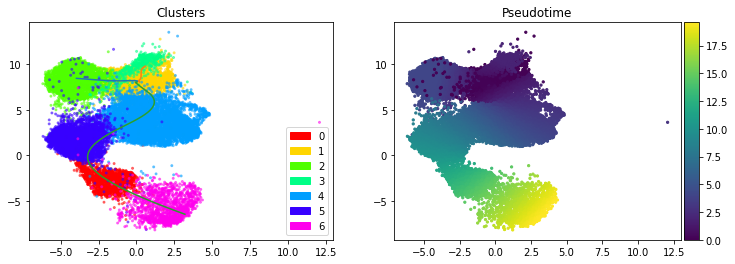

In [29]:
from pyslingshot import Slingshot 

adata = adata_healthy_original.copy() 
# start node = starting node of the minimum spanning tree
slingshot = Slingshot(adata, celltype_key="ANNOTATION_COMB", obsm_key="X_umap", start_node=1, debug_level='verbose')
slingshot.fit(num_epochs=1)
fig, axes = plt.subplots(ncols=2, figsize=(12, 4))
axes[0].set_title('Clusters')
axes[1].set_title('Pseudotime')
slingshot.plotter.curves(axes[0], slingshot.curves)
slingshot.plotter.clusters(axes[0], labels=np.arange(slingshot.num_clusters), s=4, alpha=0.5)
slingshot.plotter.clusters(axes[1], color_mode='pseudotime', s=5)
print('num cluster = ',slingshot.num_clusters)

adata.obs['slingshot_pseudotime'] = slingshot.unified_pseudotime

/home/jovyan/my-conda-envs/capital/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:364: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


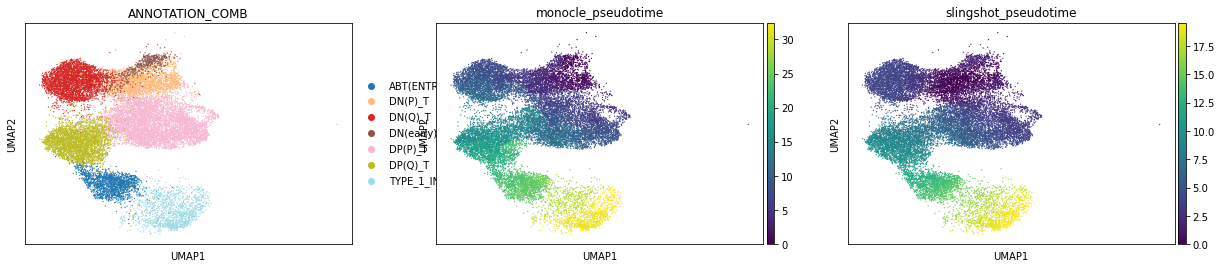

In [30]:
adata_healthy_original.obs['slingshot_pseudotime'] = adata.obs['slingshot_pseudotime']
sc.pl.umap(adata_healthy_original, color=['ANNOTATION_COMB', 'monocle_pseudotime' ,'slingshot_pseudotime'])

Lineages: [Lineage[0, 3, 1], Lineage[0, 4, 2], Lineage[0, 5]]


  0%|          | 0/1 [00:00<?, ?it/s]/home/jovyan/my-conda-envs/capital/lib/python3.8/site-packages/scipy/interpolate/_fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


Reversing from leaf to root
Averaging branch @0 with lineages: [0, 1, 2] [<pcurvepy2.pcurve.PrincipalCurve object at 0x7f9c46e14880>, <pcurvepy2.pcurve.PrincipalCurve object at 0x7f9c46e14790>, <pcurvepy2.pcurve.PrincipalCurve object at 0x7f9c46e14820>]
Shrinking branch @0 with curves: [<pcurvepy2.pcurve.PrincipalCurve object at 0x7f9c46e14880>, <pcurvepy2.pcurve.PrincipalCurve object at 0x7f9c46e14790>, <pcurvepy2.pcurve.PrincipalCurve object at 0x7f9c46e14820>]


100%|██████████| 1/1 [01:58<00:00, 118.49s/it]


num cluster =  6


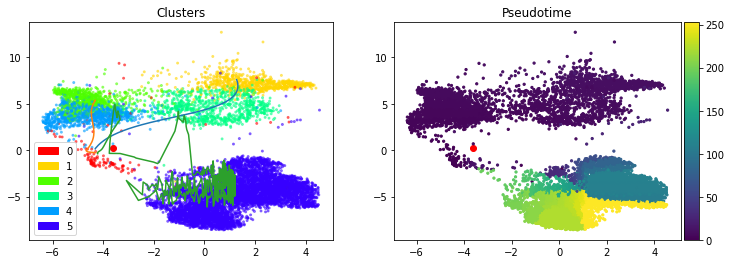

In [32]:
adata = adata_disease_original.copy() 

# start node = starting node of the minimum spanning tree
slingshot = Slingshot(adata, celltype_key="ANNOTATION_COMB", obsm_key="X_umap", start_node=0, debug_level='verbose')
slingshot.fit(num_epochs=1)
fig, axes = plt.subplots(ncols=2, figsize=(12, 4))
axes[0].set_title('Clusters')
axes[1].set_title('Pseudotime')
slingshot.plotter.curves(axes[0], slingshot.curves)
slingshot.plotter.clusters(axes[0], labels=np.arange(slingshot.num_clusters), s=4, alpha=0.5)
slingshot.plotter.clusters(axes[1], color_mode='pseudotime', s=5)
print('num cluster = ',slingshot.num_clusters)

adata.obs['slingshot_pseudotime'] = slingshot.unified_pseudotime

/home/jovyan/my-conda-envs/capital/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:364: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


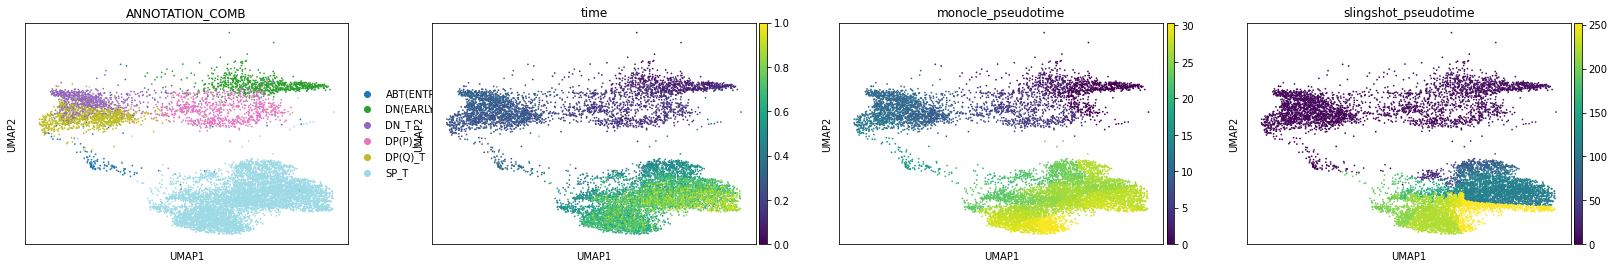

In [35]:
adata_disease_original.obs['slingshot_pseudotime'] = adata.obs['slingshot_pseudotime']
sc.pl.umap(adata_disease_original, color=['ANNOTATION_COMB', 'time', 'monocle_pseudotime' ,'slingshot_pseudotime'])

In [ ]:
# https://github.com/mossjacob/pyslingshot/blob/master/slingshot.ipynb

/home/jovyan/my-conda-envs/capital/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:364: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


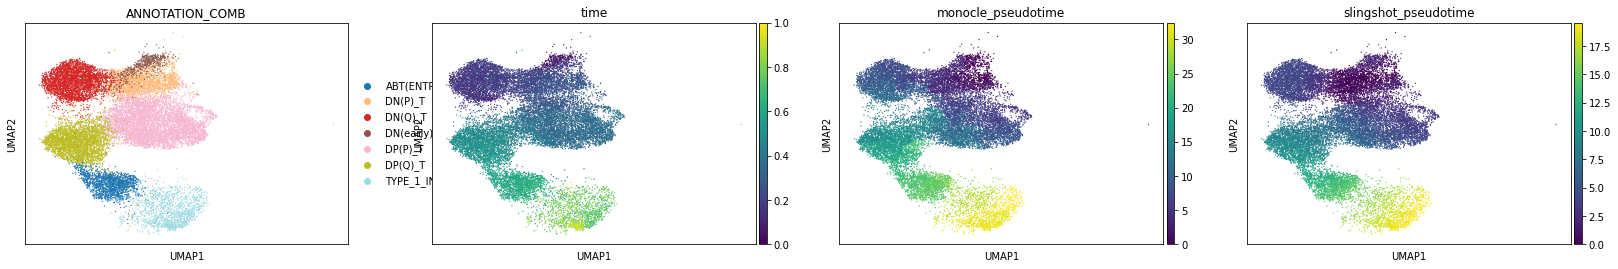

/home/jovyan/my-conda-envs/capital/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:364: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


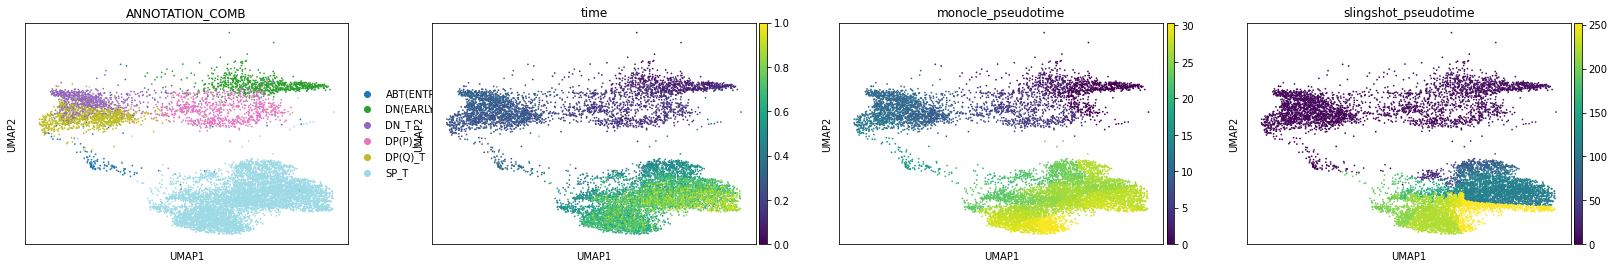

In [37]:
sc.pl.umap(adata_healthy_original, color=['ANNOTATION_COMB','time', 'monocle_pseudotime' ,'slingshot_pseudotime'])
sc.pl.umap(adata_disease_original, color=['ANNOTATION_COMB','time', 'monocle_pseudotime' ,'slingshot_pseudotime'])

<AxesSubplot: xlabel='slingshot_pseudotime', ylabel='Density'>

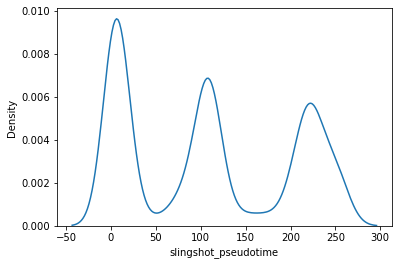

In [38]:
import seaborn as sb
sb.kdeplot(adata_disease_original.obs['slingshot_pseudotime'] )

<AxesSubplot: xlabel='monocle_pseudotime', ylabel='Density'>

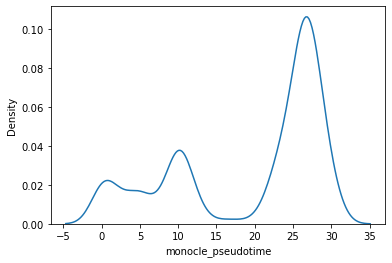

In [39]:
sb.kdeplot(adata_disease_original.obs['monocle_pseudotime'] )

<AxesSubplot: xlabel='monocle_pseudotime', ylabel='Density'>

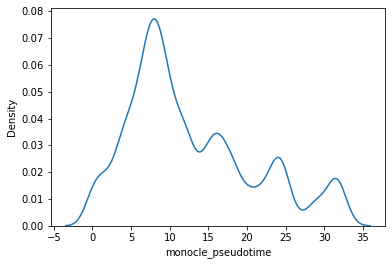

In [40]:
sb.kdeplot(adata_healthy_original.obs['monocle_pseudotime'] )

<AxesSubplot: xlabel='monocle_pseudotime', ylabel='Density'>

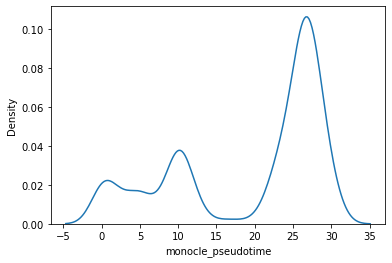

In [41]:
sb.kdeplot(adata_disease_original.obs['monocle_pseudotime'] )

In [29]:
anndata.__version__

'0.9.1'

In [ ]:
dir_path = '../GOOGLE_DRIVE_MOUNT/G2G_Analysis/G2G_paper_related/'

In [42]:
adata_healthy_original.write_h5ad('PanfetalATO_SPT_DNonwards_gplvm_ref_24012023_monocle_slingshot.h5ad')

In [44]:
adata_disease_original.write_h5ad('PanfetalATO_SPT_DNonwards_gplvm_ATO_24012023.h5ad_monocle_slingshot.h5ad')